# ASSIGNMENT 3

#### CITS5508 Machine Learning - Callum Brown (22985036)

# Section 1 - A Model for Diagnosing Cancer

## 1.1.0 Loading and Prepping the Data

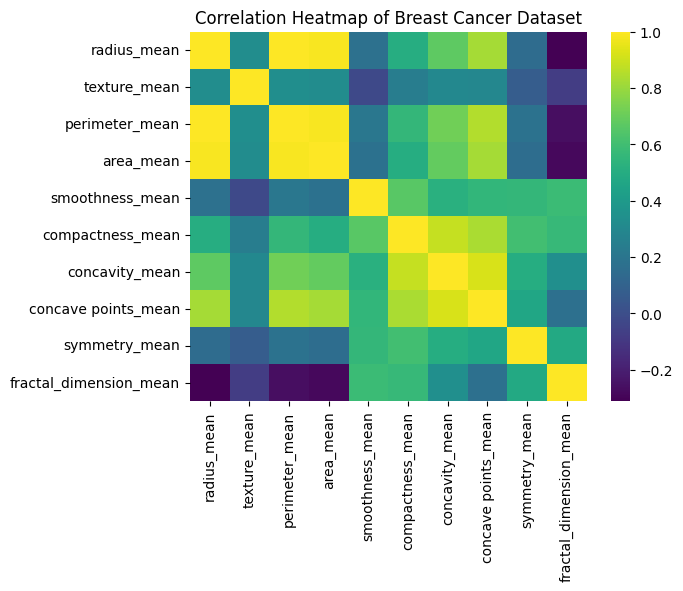

Dropping the following highly correlated features: ['perimeter_mean', 'area_mean', 'concave points_mean']


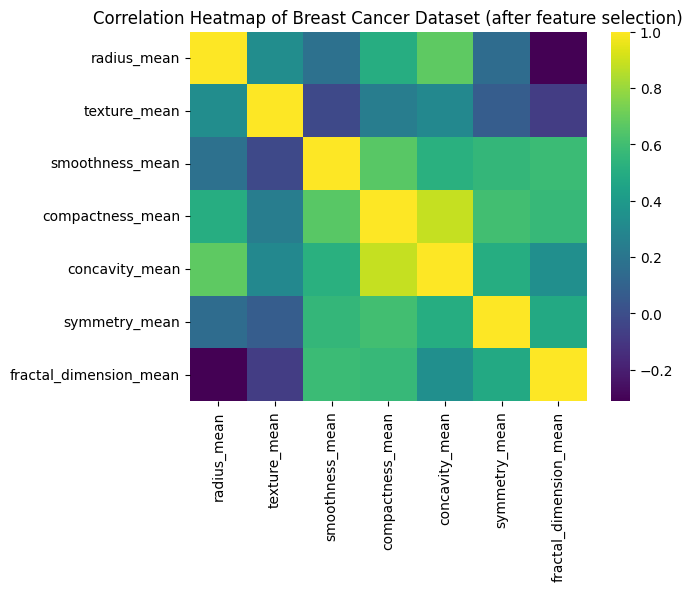

training data shape:  (455, 7)
testing data shape:  (114, 7)


In [115]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

breast_cancer = pd.read_csv("breast-cancer.csv")

# dropping the ID column as it has no impact on the diagnosis
breast_cancer = breast_cancer.drop("id", axis=1)

# drop any rows with null values
breast_cancer = breast_cancer.dropna()

# seperate into feature and target variables
x = breast_cancer.drop("diagnosis", axis=1)
y = breast_cancer["diagnosis"]

# create correlation matrix
feature_corr = x.corr()
sns.heatmap(feature_corr, cmap='viridis')
plt.title("Correlation Heatmap of Breast Cancer Dataset")
plt.show()

# Using some maths and the correlation matrix to remove the linearly correlated features
# written as a function for use in the coming datasets
def drop_linearity(data, threshold):
    linear_features = []
    for row in data:
        if row in linear_features:
            continue
        for column in data:
            if row == column: 
               continue
            if data.at[row, column] > threshold or data.at[row, column] < -threshold:
                linear_features.append(column)
    return linear_features

# call the function on the feature matrix
lf = drop_linearity(feature_corr, 0.9)
print("Dropping the following highly correlated features:", lf)
# dropping these features
x = x.drop(lf, axis=1)

# create correlation matrix
feature_corr = x.corr()
sns.heatmap(feature_corr, cmap='viridis')
plt.title("Correlation Heatmap of Breast Cancer Dataset (after feature selection)")
plt.show()

# split the data into training and testing subsets
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2, random_state=69)

# scale the data based on the training data
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr)
x_te = scaler.transform(x_te)

print("training data shape: ", x_tr.shape)
print("testing data shape: ", x_te.shape)

## 1.1.1 Training a Decision Tree Model

In [116]:
# define the parameter grid for some common hyperparameters for use in grid search.
parameter_grid = {
    'max_depth': [None, 2, 3, 4, 5, 7],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

# construct a decision tree classifier object
dt = DecisionTreeClassifier(random_state=69)

# three fold cross validation using grid search to optimise the model
grid_search = GridSearchCV(dt, parameter_grid, cv=3)
grid_search.fit(x_tr, y_tr)

# A list of the best parameters
best_params = grid_search.best_params_

# Print the results of the cross-validation grid search
print("Decision Tree Model")
print("Best hyperparameters:", best_params)
print("Cross-validation accuracy score: {:.4f}%".format(grid_search.best_score_*100))

# retrain the classifier with the best parameters found by the grid search
dt_f = DecisionTreeClassifier(random_state=69, **best_params)

# fit the model to the training data and predict the target values of the testing data
dt_f.fit(x_tr, y_tr)
dt_yp = dt_f.predict(x_te)

Decision Tree Model
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Cross-validation accuracy score: 93.4094%


## 1.1.2 Training a Logistic Regression Model

In [117]:
from sklearn.linear_model import LogisticRegression

# define the parameter grid for some common hyperparameters for use in grid search.
parameter_grid = {
    # regularisation strength (how close the model fits the training data)
    'C': [0.01, 0.1, 0.5, 1, 10],
    # the algorithm used for the optimisation problem
    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'saga', 'sag']
}

# construct a logistic regression object
lr = LogisticRegression(random_state=69, max_iter=20000)

# three fold cross validation using grid search to optimise the model
grid_search = GridSearchCV(lr, parameter_grid, cv=3)
grid_search.fit(x_tr, y_tr)

# A list of the best parameters
best_params = grid_search.best_params_

# Print the results of the cross-validation grid search
print("Logistic Regression Model")
print("Best hyperparameters:", best_params)
print("Cross-validation accuracy score: {:.4f}%".format(grid_search.best_score_*100))

# retrain the model with the best parameters from the grid search
lr_f = LogisticRegression(random_state=69, **best_params)

# fit the model to the training data and predict the target values of the testing data
lr_f.fit(x_tr, y_tr)
lr_yp = lr_f.predict(x_te)

Logistic Regression Model
Best hyperparameters: {'C': 0.5, 'solver': 'liblinear'}
Cross-validation accuracy score: 95.6039%


## 1.1.2 Comparing the Performance of the two Models

Decision Tree Classifier Metrics:
Accuracy: 87.7193%
Precision: 91.6667%
Recall: 81.4815%
F1-Score: 86.2745%

Logistic Regression Model Metrics:
Accuracy: 89.4737%
Precision: 92.0000%
Recall: 85.1852%
F1-Score: 88.4615%



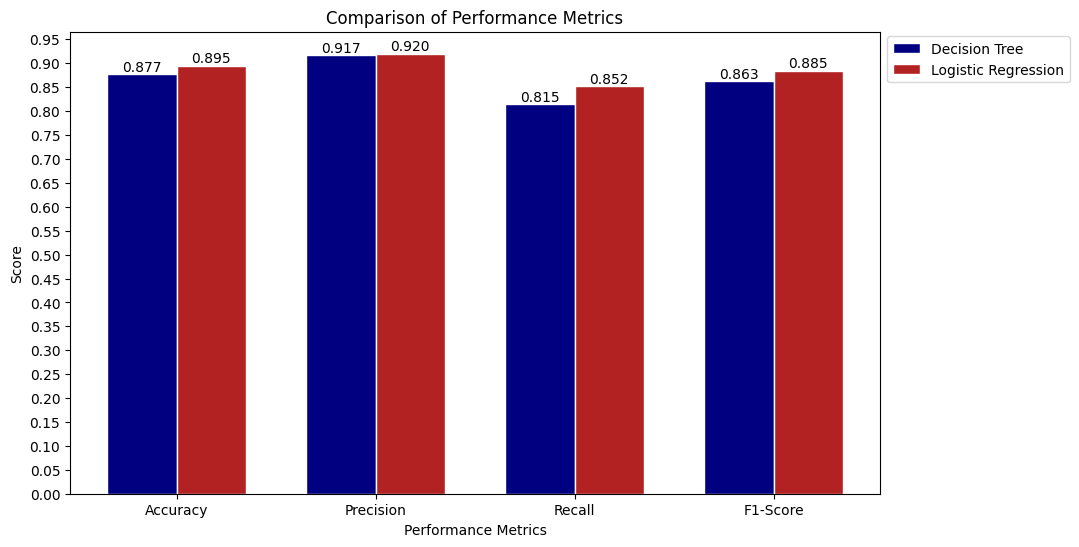

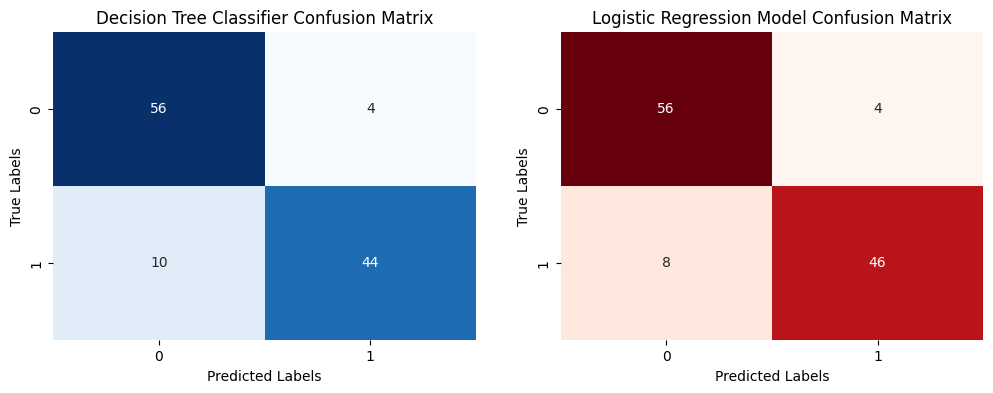

In [118]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
              
# get the confusion matrix of each model
dt_cm = confusion_matrix(y_te, dt_yp)
lr_cm = confusion_matrix(y_te, lr_yp)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
dt_scores = []
lr_scores = []

# add the metrics to the list one by one
dt_scores.append(accuracy_score(y_te, dt_yp))
dt_scores.append(precision_score(y_te, dt_yp, pos_label='M'))
dt_scores.append(recall_score(y_te, dt_yp, pos_label='M'))
dt_scores.append(f1_score(y_te, dt_yp, pos_label='M'))

lr_scores.append(accuracy_score(y_te, lr_yp))
lr_scores.append(precision_score(y_te, lr_yp, pos_label='M'))
lr_scores.append(recall_score(y_te, lr_yp, pos_label='M'))
lr_scores.append(f1_score(y_te, lr_yp, pos_label='M'))

print("Decision Tree Classifier Metrics:")
print("Accuracy: {:.4f}%".format(100*dt_scores[0]))
print("Precision: {:.4f}%".format(100*dt_scores[1]))
print("Recall: {:.4f}%".format(100*dt_scores[2]))
print("F1-Score: {:.4f}%\n".format(100*dt_scores[3])) 

print("Logistic Regression Model Metrics:")
print("Accuracy: {:.4f}%".format(100*lr_scores[0]))
print("Precision: {:.4f}%".format(100*lr_scores[1]))
print("Recall: {:.4f}%".format(100*lr_scores[2]))
print("F1-Score: {:.4f}%\n".format(100*lr_scores[3]))

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(metrics))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.figure(figsize=(12,6))
plt.bar(r1, dt_scores, color='navy', width=bar_width, edgecolor='white', label='Decision Tree')
plt.bar(r2, lr_scores, color='firebrick', width=bar_width, edgecolor='white', label='Logistic Regression')

# Add labels, title, and ticks
plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Comparison of Performance Metrics')
plt.xticks([r + bar_width/2 for r in range(len(metrics))], metrics)
plt.yticks(np.arange(0,1,0.05))

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.94))

# Adjust the layout to accommodate the legend
plt.subplots_adjust(right=0.8)

# Add annotations to the bars
for i, score in enumerate(dt_scores):
    plt.text(i, score, f'{score:.3f}', ha='center', va='bottom', color='black')

for i, score in enumerate(lr_scores):
    plt.text(i + bar_width, score, f'{score:.3f}', ha='center', va='bottom', color='black')

# Show the plot
plt.show()

# Create a figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Create a heatmap of the confusion matrix for the decision tree classifier
sns.heatmap(dt_cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")
axes[0].set_title("Decision Tree Classifier Confusion Matrix")

# creating a heatmap for the logistic regressor confusion matrix
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Reds", cbar=False, ax=axes[1])
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")
axes[1].set_title("Logistic Regression Model Confusion Matrix")
plt.show()

## 1.2 The Impacts of Features on the Different Models and their Performance

## 1.3 A PCA Scatterplot of the First two Principal Components

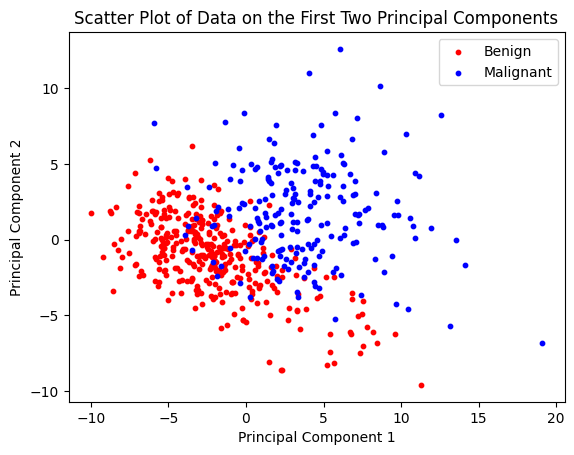

Proportion of Data Variance Explained by First Two Principal Components:
First PC: 68.6556%
Second PC: 31.3237%
Total: 99.9792%


In [119]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)  # Set the number of components to 2
x_pca = pca.fit_transform(x)  # Apply PCA transformation
explained_variance_ratio = pca.explained_variance_ratio_  # Get explained variance ratio

class_labels = ['B', 'M']
colors = ['red', 'blue']

# Create the scatter plot
plt.scatter(x_pca[y == class_labels[0], 0], x_pca[y == class_labels[0], 1], c=colors[0], label='Benign', s=10)
plt.scatter(x_pca[y == class_labels[1], 0], x_pca[y == class_labels[1], 1], c=colors[1], label='Malignant', s=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Data on the First Two Principal Components')
plt.legend()
plt.show()

print("Proportion of Data Variance Explained by First Two Principal Components:")
print("First PC: {:.4f}%".format(explained_variance_ratio[0] * 100))
print("Second PC: {:.4f}%".format(explained_variance_ratio[1] * 100))
print("Total: {:.4f}%".format(100*sum(explained_variance_ratio)))

## 1.4  A Biplot of the 

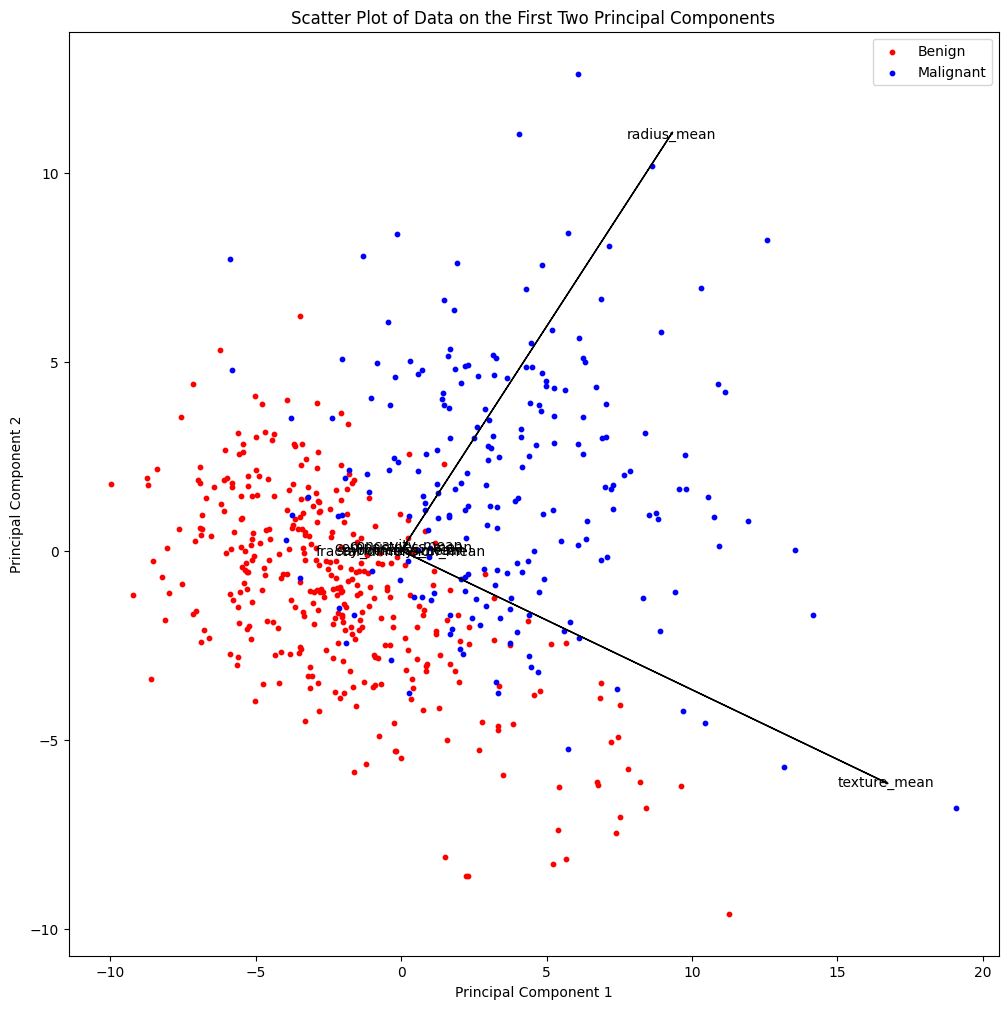

In [121]:
# Perform PCA
pca = PCA(n_components=2)  # Set the number of components to 2
x_pca = pca.fit_transform(x)  # Apply PCA transformation
explained_variance_ratio = pca.explained_variance_ratio_  # Get explained variance ratio

class_labels = ['B', 'M']
colors = ['red', 'blue']

# Create the scatter plot
plt.figure(figsize=(12,12))
plt.scatter(x_pca[y == class_labels[0], 0], x_pca[y == class_labels[0], 1], c=colors[0], label='Benign', s=10)
plt.scatter(x_pca[y == class_labels[1], 0], x_pca[y == class_labels[1], 1], c=colors[1], label='Malignant', s=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Data on the First Two Principal Components')


# Add variable vectors to the plot
feature_vectors = pca.components_.T
for i, feature in enumerate(x):
    plt.arrow(0, 0, feature_vectors[i, 0] * max(x_pca[:, 0]), feature_vectors[i, 1] * max(x_pca[:, 1]), width=0.005, head_width=0.05)
    plt.text(feature_vectors[i, 0] * max(x_pca[:, 0]), feature_vectors[i, 1] * max(x_pca[:, 1]), feature, ha='center', va='center')

plt.legend()
plt.show()

## 1.5 Exploring the Relevance of Features to the Target Data


## 1.6 a lot of shit to do here lol

# Section 2 - A clustering analysis on airlines safety records

## 2.1 K-Means Clustering and Silhoutte Scores
Silhoutte score indicates the resulting quality of clusters generated by K-Means clustering. The silhoutte score takes into account two factors, cohesion or how precise datapoints are in the same cluster, and separation or how well sepearated different clusters in the data are. The silhoutte score value varies from -1 to 1, where a value closer to 1 means points are more likely to be assigned to their correct cluster. 

From the graph, we observe the highest silhoutte score at K=2, with a value of almost 0.8. As the K value increases, the corresponding silhoutte score value decreases in an approximately linear fashion, however there is a larger drop from K=4 to K=5. We finish at K=8, where the silhoutte score value is 0.625. Therefore, we select the K=2 as our value, as it yields the largest silhoutte score. 

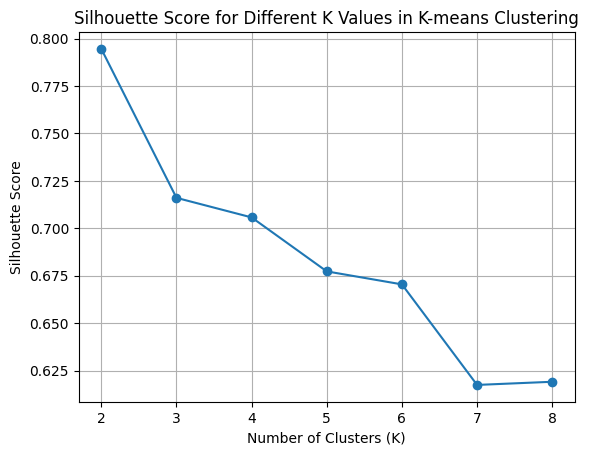

In [122]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set the random state for reproducibility
random_state = 5508

airline_safety = pd.read_csv("airline-safety.csv")

# split the data into feature and target, removing the non numerical target from the feature variables
x = airline_safety.drop("airline", axis=1)
y = airline_safety["airline"]

# scaling the data so each feature has equal importance
scaler = StandardScaler()
x_s = scaler.fit_transform(x)
x_s = pd.DataFrame(x_s)
x_s.columns = airline_safety.drop("airline", axis=1).columns

# Range of K values to test
k_values = range(2, 9)

# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Perform K-means clustering for each K value and calculate the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
    labels = kmeans.fit_predict(x)
    score = silhouette_score(x, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K Values in K-means Clustering')
plt.grid(True)
plt.show()

## 2.2 Applying K-Means Clustering

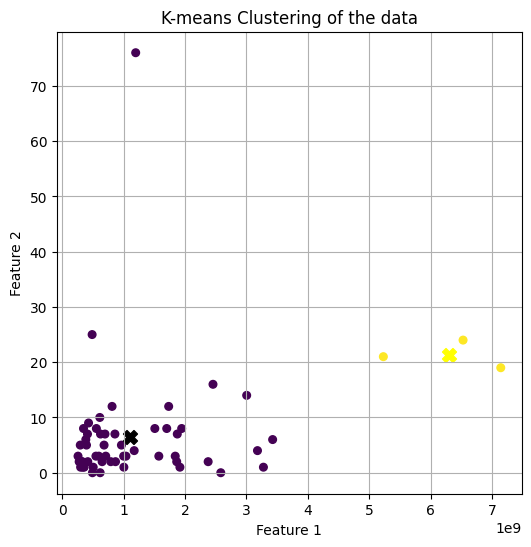

Cluster 0 Safety Record (Averages)
Group Size:  53
1985-1999
	Incidents: 6.38
	Fatal Accidents: 1.83
	Fatalities: 103.17
2000-2014
	Incidents: 3.32
	Fatal Accidents: 0.57
	Fatalities: 47.79

Cluster 1 Safety Record (Averages)
Group Size:  3
1985-1999
	Incidents: 21.33
	Fatal Accidents: 8.33
	Fatalities: 275.67
2000-2014
	Incidents: 18.33
	Fatal Accidents: 2.33
	Fatalities: 192.00



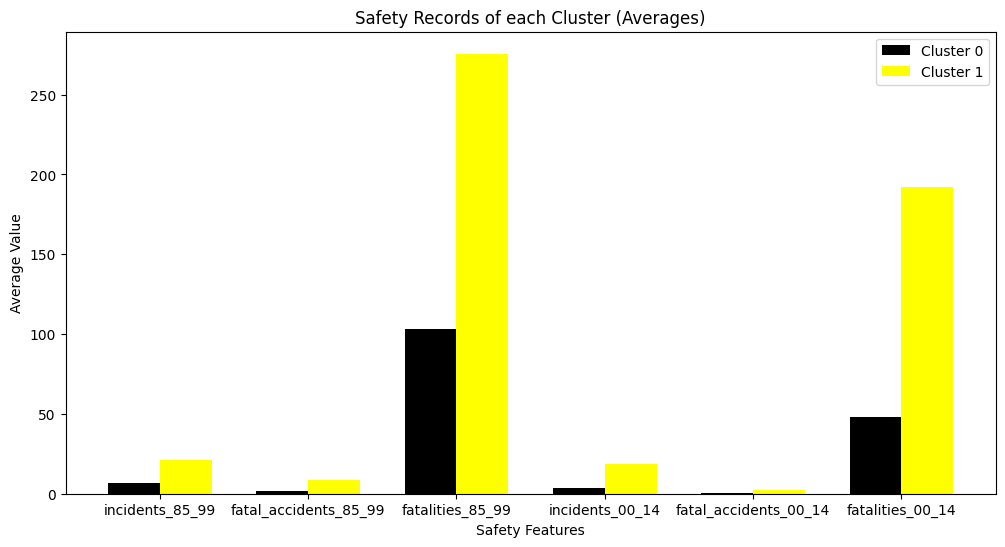

In [123]:
# Set the optimal value of K obtained in Task 1
K = 2

# Initialize and fit the K-means clustering model
kmeans = KMeans(n_clusters=K, random_state=random_state, n_init='auto')
kmeans.fit(x)

# Get the cluster labels for each data point
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plotting the data points with different colors for each cluster
plt.figure(figsize=(6,6))
plt.scatter(x.values[:, 0], x.values[:, 1], c=labels, s=30)
# Plotting the centroid positions
plt.scatter(centroids[0, 0], centroids[0, 1], marker='X', c='black', s=100)
plt.scatter(centroids[1, 0], centroids[1, 1], marker='X', c='yellow', s=100)
plt.grid()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering of the data')
plt.show()

# Create a DataFrame with the data and cluster labels
x_l = x.copy()
x_l['Cluster'] = labels

record_features = airline_safety.drop(["airline", "avail_seat_km_per_week"], axis=1).columns
safety_record1 = []
safety_record2 = []
plt.figure(figsize=(12, 6))

# Interpret the characteristics of each group
for i in range(K):
    # create a copy of the data
    cluster_data = x_l[x_l['Cluster'] == i]
    group_size = len(cluster_data)
    safety_record = []
        
    # print out the average value of each feature concerned with safety for each cluster
    # store each value in a 'safety record' for plotting
    print("Cluster {} Safety Record (Averages)".format(int(i)))
    print("Group Size: ", group_size)
    print("1985-1999")
    safety_record.append(cluster_data["incidents_85_99"].mean())
    print("\tIncidents: {:.2f}".format(safety_record[0]))
    safety_record.append(cluster_data["fatal_accidents_85_99"].mean())
    print("\tFatal Accidents: {:.2f}".format(safety_record[1]))  
    safety_record.append(cluster_data["fatalities_85_99"].mean())
    print("\tFatalities: {:.2f}".format(safety_record[2]))
    print("2000-2014")
    safety_record.append(cluster_data["incidents_00_14"].mean())
    print("\tIncidents: {:.2f}".format(safety_record[3]))
    safety_record.append(cluster_data["fatal_accidents_00_14"].mean())
    print("\tFatal Accidents: {:.2f}".format(safety_record[4]))  
    safety_record.append(cluster_data["fatalities_00_14"].mean())
    print("\tFatalities: {:.2f}\n".format(safety_record[5]))
    
    # assigning the array to a seperate record based on group 
    if int(i) == 0:
        safety_record1 = safety_record
    else:
        safety_record2 = safety_record

# plotting the safety record values of the two groups
bar_width = 0.35
xpos = np.arange(len(record_features))
plt.bar(xpos-bar_width/2, safety_record1, bar_width, label='Cluster 0', color="black")
plt.bar(xpos+bar_width/2, safety_record2, bar_width, label='Cluster 1', color="yellow")    
plt.xticks(xpos, record_features)
plt.xlabel("Safety Features")
plt.ylabel("Average Value")
plt.title("Safety Records of each Cluster (Averages)")
plt.legend()
plt.show()

## 2.3 The Effect of Scaling and Feature Selection on K-Means Clustering Performance

## 2.4 K-Means Cluster Analysis and Comparison of Data from the two Time Periods


Distribution of Datapoints across Clusters
Group 0 in the 85-99 data: 14 entries
Group 1 in the 85-99 data: 42 entries
Group 0 in the 00-14 data: 51 entries
Group 1 in the 00-14 data: 5 entries


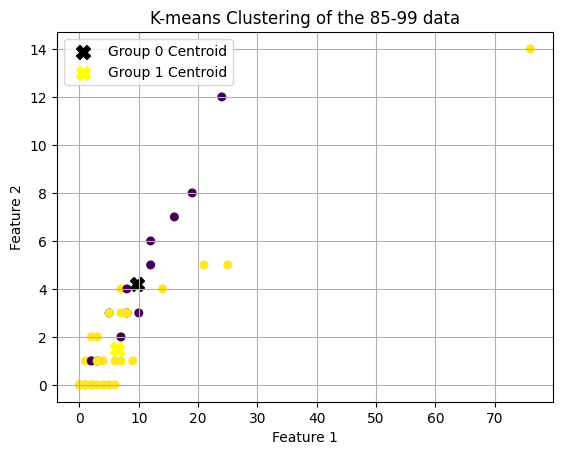

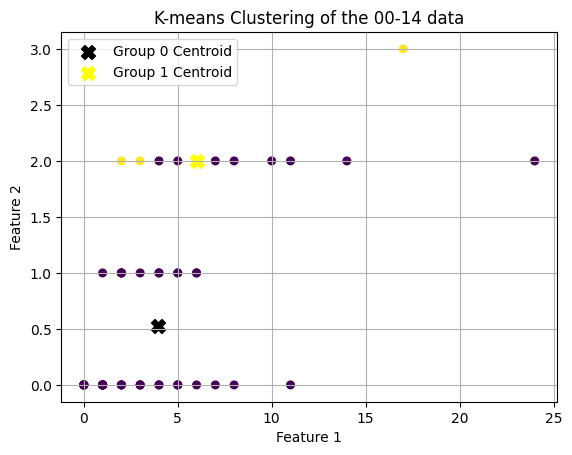

In [124]:
# creating two seperate datasets, one for each time period
x85 = airline_safety.drop(["airline", "avail_seat_km_per_week", "incidents_00_14", "fatal_accidents_00_14", "fatalities_00_14"], axis=1).values
x00 = airline_safety.drop(["airline", "avail_seat_km_per_week", "incidents_85_99", "fatal_accidents_85_99", "fatalities_85_99"], axis=1).values

# two cluster analyses, one for each time period
kmeans85 = KMeans(n_clusters=K, random_state=random_state, n_init='auto')
kmeans00 = KMeans(n_clusters=K, random_state=random_state, n_init='auto')
kmeans85.fit(x85)
kmeans00.fit(x00)

# get the labels and cluster centroid coordinates
labels85 = kmeans85.labels_
labels00 = kmeans00.labels_
centroid85 = kmeans85.cluster_centers_
centroid00 = kmeans00.cluster_centers_

# print the number of datapoints in each cluster
print("Distribution of Datapoints across Clusters")
print("Group 0 in the 85-99 data: {} entries".format(np.count_nonzero(labels85 == 0)))
print("Group 1 in the 85-99 data: {} entries".format(np.count_nonzero(labels85 == 1)))
print("Group 0 in the 00-14 data: {} entries".format(np.count_nonzero(labels00 == 0)))
print("Group 1 in the 00-14 data: {} entries".format(np.count_nonzero(labels00 == 1)))

# Plotting the data points with different colors for each cluster
plt.scatter(x85[:, 0], x85[:, 1], c=labels85, s=30)
# Plotting the centroid positions
plt.scatter(centroid85[0, 0], centroid85[0, 1], marker='X', c='black', s=100, label="Group 0 Centroid")
plt.scatter(centroid85[1, 0], centroid85[1, 1], marker='X', c='yellow', s=100, label="Group 1 Centroid")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.legend()
plt.title('K-means Clustering of the 85-99 data')
plt.show()

# Plotting the data points with different colors for each cluster
#plt.figure(figsize=(6,6))
plt.scatter(x00[:, 0], x00[:, 1], c=labels00, s=30)
# Plotting the centroid positions
plt.scatter(centroid00[0, 0], centroid00[0, 1], marker='X', c='black', s=100, label="Group 0 Centroid")
plt.scatter(centroid00[1, 0], centroid00[1, 1], marker='X', c='yellow', s=100, label="Group 1 Centroid")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.title('K-means Clustering of the 00-14 data')
plt.show()


## 2.5 K-Means Cluster Analysis of the Safety Improvement of Airlines from 1985 to 1999 and 2000 to 2014

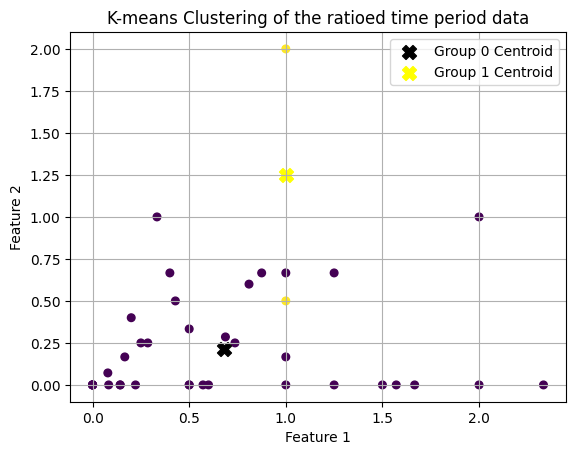

In [125]:
# creating a new dataframe for the ratio values of each feature
x_r = pd.DataFrame()
x_r["Incidents"] = x["incidents_00_14"] / x["incidents_85_99"] 
x_r["Fatal Accidents"] = x["fatal_accidents_00_14"] / x["fatal_accidents_85_99"]
x_r["Fatalities"] = x["fatalities_00_14"] / x["fatalities_85_99"]

# Remove rows with null or infinite values
x_r = x_r.replace([np.inf, -np.inf], np.nan).dropna(how='any')

x_r_v = x_r.values

kmeans_r = KMeans(n_clusters=K, random_state=random_state, n_init='auto')
kmeans_r.fit(x_r_v)

labels_r = kmeans_r.labels_
centroids_r = kmeans_r.cluster_centers_

# Plotting the data points with different colors for each cluster
plt.scatter(x_r_v[:, 0], x_r_v[:, 1], c=labels_r, s=30)
# Plotting the centroid positions
plt.scatter(centroids_r[0, 0], centroids_r[0, 1], marker='X', c='black', s=100, label="Group 0 Centroid")
plt.scatter(centroids_r[1, 0], centroids_r[1, 1], marker='X', c='yellow', s=100, label="Group 1 Centroid")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.title('K-means Clustering of the ratioed time period data')
plt.show()

# Section 3 - Clustering Analysis on US Arrests Data

## 3.1 Hierarchical Clustering

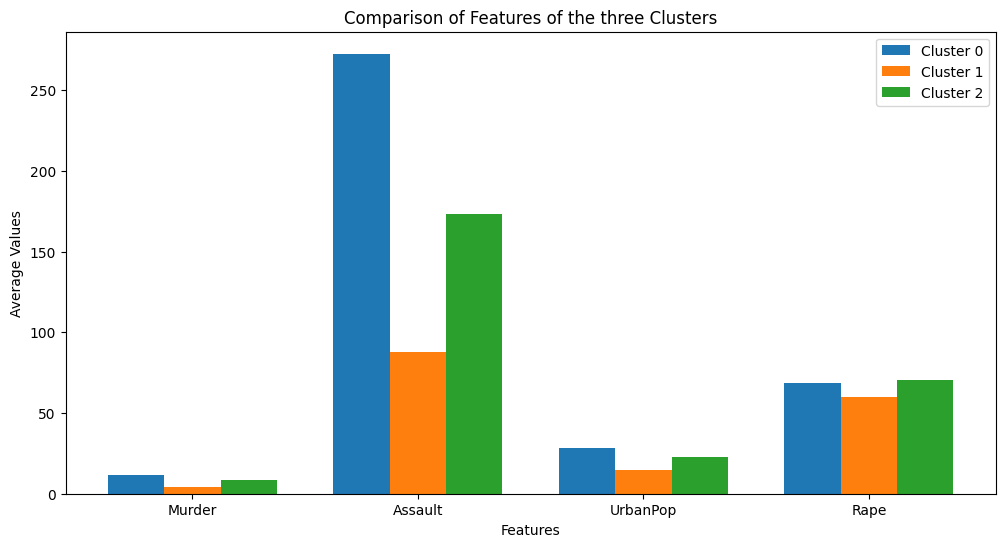

Cluster 1 States:
Index(['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware', 'Florida',
       'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi',
       'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina'],
      dtype='object', name='State')

Cluster 1 Characteristics:
         Murder     Assault   UrbanPop       Rape
count  16.00000   16.000000  16.000000  16.000000
mean   11.81250  272.562500  68.312500  28.375000
std     2.79592   31.052576  15.490723   9.602882
min     5.90000  236.000000  44.000000  15.800000
25%    10.30000  251.250000  55.500000  21.950000
50%    11.75000  261.000000  71.000000  26.950000
75%    13.50000  287.250000  80.250000  32.850000
max    16.10000  337.000000  91.000000  46.000000

Cluster 2 States:
Index(['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska',
       'New Hampshire', 'North Dakota', 'Ohio', 'Pennsylvania', 'South Dakota',
       '

In [126]:
from sklearn.cluster import AgglomerativeClustering

# Step 1: Load the dataset
data = pd.read_csv('USArrests.csv', index_col=0)

# Step 3: Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete')
clusters = clustering.fit_predict(data)

# Step 4: Assign states to their respective clusters and describe their characteristics
cluster_labels = pd.Series(clusters, index=data.index)

# Get states in each cluster
cluster_1_states = cluster_labels[cluster_labels == 0].index
cluster_2_states = cluster_labels[cluster_labels == 1].index
cluster_3_states = cluster_labels[cluster_labels == 2].index

# Describe characteristics of each cluster
c1c = data.loc[cluster_1_states].describe()
c2c = data.loc[cluster_2_states].describe()
c3c = data.loc[cluster_3_states].describe()

# Get the average statistics for plotting
plt_c1 = [c1c["Murder"][1], c1c["Assault"][1], c1c["Rape"][1], c1c["UrbanPop"][1]]
plt_c2 = [c2c["Murder"][1], c2c["Assault"][1], c2c["Rape"][1], c2c["UrbanPop"][1]]
plt_c3 = [c3c["Murder"][1], c3c["Assault"][1], c3c["Rape"][1], c3c["UrbanPop"][1]]

# some calcs to plot a comparison bar chart
bw = 0.25
xpos = np.arange(len(data.columns))
plt.figure(figsize=(12, 6))
plt.bar(xpos, plt_c1, width=bw, label="Cluster 0")
plt.bar(xpos + bw, plt_c2, width=bw, label="Cluster 1")
plt.bar(xpos + 2*bw, plt_c3, width=bw, label="Cluster 2")
plt.xlabel("Features")
plt.ylabel("Average Values")
plt.title("Comparison of Features of the three Clusters")
plt.xticks(xpos+bw, data.columns)
plt.legend()
plt.show()

# Print the states and their characteristics in each cluster
print("Cluster 1 States:")
print(cluster_1_states)
print("\nCluster 1 Characteristics:")
print(c1c)

print("\nCluster 2 States:")
print(cluster_2_states)
print("\nCluster 2 Characteristics:")
print(c2c)

print("\nCluster 3 States:")
print(cluster_3_states)
print("\nCluster 3 Characteristics:")
print(c3c)

## 3.2 Repeating 3.1 with Scaled Data and Comparing the Results

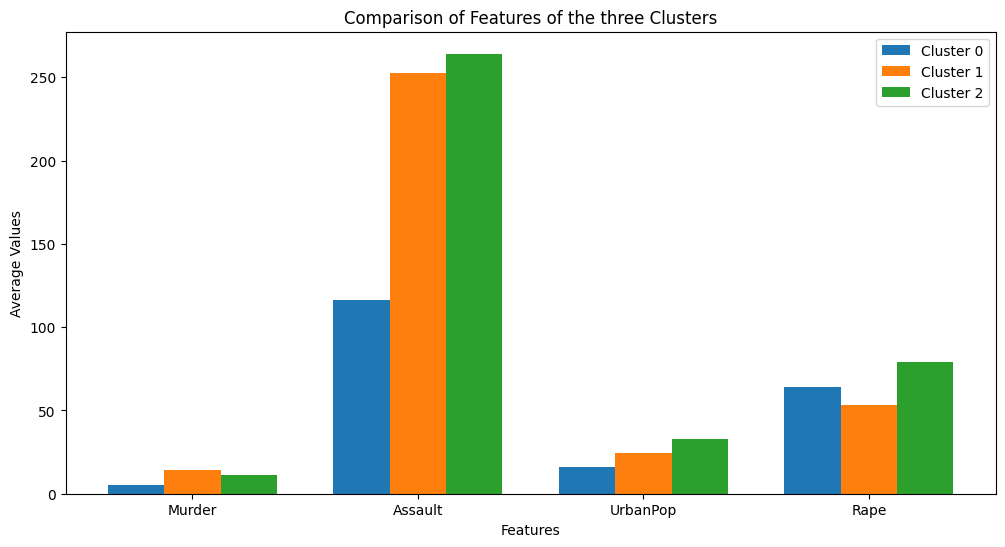

Cluster 1 States:
Index(['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota',
       'Missouri', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object', name='State')

Cluster 1 Characteristics:
          Murder     Assault   UrbanPop       Rape
count  31.000000   31.000000  31.000000  31.000000
mean    5.003226  116.483871  63.838710  16.338710
std     2.383902   48.059596  14.210552   5.802395
min     0.800000   45.000000  32.000000   7.300000
25%     2.950000   82.000000  53.500000  11.250000
50%     4.900000  113.000000  66.000000  16.300000
75%     6.700000  153.500000  72.500000  20.100000
max     9.700000  238.000000  89.000000  29.300000

Cluster 2 States:
Index(['Alaba

In [127]:
from sklearn.cluster import AgglomerativeClustering

# Step 1: Load the dataset
data = pd.read_csv('USArrests.csv', index_col=0)

# Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Step 3: Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete')
clusters = clustering.fit_predict(scaled_data)

# Step 4: Assign states to their respective clusters and describe their characteristics
cluster_labels = pd.Series(clusters, index=data.index)

# Get states in each cluster
cluster_1_states = cluster_labels[cluster_labels == 0].index
cluster_2_states = cluster_labels[cluster_labels == 1].index
cluster_3_states = cluster_labels[cluster_labels == 2].index

# Describe characteristics of each cluster
c1c = data.loc[cluster_1_states].describe()
c2c = data.loc[cluster_2_states].describe()
c3c = data.loc[cluster_3_states].describe()

# Get the average statistics for plotting
plt_c1 = [c1c["Murder"][1], c1c["Assault"][1], c1c["Rape"][1], c1c["UrbanPop"][1]]
plt_c2 = [c2c["Murder"][1], c2c["Assault"][1], c2c["Rape"][1], c2c["UrbanPop"][1]]
plt_c3 = [c3c["Murder"][1], c3c["Assault"][1], c3c["Rape"][1], c3c["UrbanPop"][1]]

# some calcs to plot a comparison bar chart
bw = 0.25
xpos = np.arange(len(data.columns))
plt.figure(figsize=(12, 6))
plt.bar(xpos, plt_c1, width=bw, label="Cluster 0")
plt.bar(xpos + bw, plt_c2, width=bw, label="Cluster 1")
plt.bar(xpos + 2*bw, plt_c3, width=bw, label="Cluster 2")
plt.xlabel("Features")
plt.ylabel("Average Values")
plt.title("Comparison of Features of the three Clusters")
plt.xticks(xpos+bw, data.columns)
plt.legend()
plt.show()

# Print the states and their characteristics in each cluster
print("Cluster 1 States:")
print(cluster_1_states)
print("\nCluster 1 Characteristics:")
print(c1c)

print("\nCluster 2 States:")
print(cluster_2_states)
print("\nCluster 2 Characteristics:")
print(c2c)

print("\nCluster 3 States:")
print(cluster_3_states)
print("\nCluster 3 Characteristics:")
print(c3c)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# performing PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# getting the linkage matrix and performing hierarchical clustering on the principal component score vectors
linkage_matrix = linkage(principal_components, method='complete', metric='euclidean')
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete')
clusters = clustering.fit_predict(principal_components)

# construct the dendrogram
dendrogram = dendrogram(linkage_matrix)

# plot the dendrogram
plt.title('Hierarchical Clustering Dendrogram (Principal Components)')
plt.xlabel('States')
plt.ylabel('Distance')
plt.show()

# a scatter plot of the first two principal components with different colors for each cluster
plt.scatter(principal_components[clusters == 0, 0], principal_components[clusters == 0, 1], c='red', label='Cluster 1')
plt.scatter(principal_components[clusters == 1, 0], principal_components[clusters == 1, 1], c='green', label='Cluster 2')
plt.scatter(principal_components[clusters == 2, 0], principal_components[clusters == 2, 1], c='blue', label='Cluster 3')
plt.title('PCA - Scatter Plot of First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.legend()
# move the legend outside the plot
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
# Step 10: Display the scatter plot
plt.show()

In [ ]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete')
clusters = clustering.fit_predict(principal_components)
cluster_means = []

for cluster_id in range(3):
    cluster_mean = principal_components[clusters == cluster_id].mean(axis=0)
    cluster_means.append(cluster_mean)

initial_centroids = pca.inverse_transform(cluster_means)

# Step 5: Perform K-means clustering using the initial centroids and Euclidean distance
kmeans = KMeans(n_clusters=3, random_state=random_state, n_init='auto')
kmeans_clusters = kmeans.fit_predict(principal_components)

# Step 6: Create a scatter plot of the first two principal components with different colors for each cluster
plt.scatter(principal_components[kmeans_clusters == 0, 0], principal_components[kmeans_clusters == 0, 1], c='red', label='Cluster 1')
plt.scatter(principal_components[kmeans_clusters == 1, 0], principal_components[kmeans_clusters == 1, 1], c='green', label='Cluster 2')
plt.scatter(principal_components[kmeans_clusters == 2, 0], principal_components[kmeans_clusters == 2, 1], c='blue', label='Cluster 3')

# Step 7: Customize the scatter plot
plt.title('K-means Clustering - Scatter Plot of First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Step 8: Display the scatter plot
plt.show()